In [35]:
# import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset from the excel file
file_path = 'all-euro-data-2023-2024.xlsx'
df_epl = pd.read_excel(file_path, sheet_name='E0')
df_bundesliga = pd.read_excel(file_path, sheet_name='D1')
df_laliga = pd.read_excel(file_path, sheet_name='SP1')
df_ligue1 = pd.read_excel(file_path, sheet_name='F1')
df_seriea = pd.read_excel(file_path, sheet_name='I1')


# concatenate all the dataframes into one
df = pd.concat([df_epl, df_bundesliga, df_laliga, df_ligue1, df_seriea], ignore_index=True)

df.tail(), df.shape
                   

(    Div       Date      Time    HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  \
 771  I1 2023-12-17  14:00:00  Fiorentina       Verona     1     0   H     0   
 772  I1 2023-12-17  14:00:00     Udinese     Sassuolo     2     2   D     1   
 773  I1 2023-12-17  17:00:00     Bologna         Roma     2     0   H     1   
 774  I1 2023-12-17  19:45:00       Lazio        Inter     0     2   A     0   
 775  I1 2023-12-18  19:45:00    Atalanta  Salernitana     4     1   H     0   
 
      HTAG  ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  \
 771     0  ...     1.98 -1.00      1.84      2.09   1.85   2.09     1.85   
 772     0  ...     2.00 -0.25      2.10      1.70   2.20   1.77     2.20   
 773     0  ...     1.44 -0.25      2.13      1.81   2.14   1.81     2.16   
 774     1  ...     1.72  0.50      1.98      1.95   1.99   1.93     2.15   
 775     1  ...     2.39 -1.75      2.02      1.91   2.00   1.90     2.02   
 
      MaxCAHA  AvgCAHH  AvgCAHA  
 771     2.15     1.

## Data Cleaning

In [36]:
# steps:
# 1. Check for missing values
missing_values = df.isnull().sum()

# 2. Check for duplicates
duplicate_rows = df.duplicated().sum()

# Display the results of the checks
missing_values, duplicate_rows

(Div         0
 Date        0
 Time        0
 HomeTeam    0
 AwayTeam    0
            ..
 PCAHA       0
 MaxCAHH     1
 MaxCAHA     1
 AvgCAHH     0
 AvgCAHA     0
 Length: 106, dtype: int64,
 0)

In [37]:
# Dropping columns with a high number of missing values or irrelevant to our analysis
irrelevant_columns = df.columns[df.isnull().sum() > (0.5 * len(df))]  # Columns with more than 50% missing values
df_cleaned = df.drop(columns=irrelevant_columns)

# Convert 'Date' to datetime
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Fill missing values in other relevant columns with appropriate values (like median or mode)
# For numerical columns, we use median and for categorical, we use mode
for column in df_cleaned.columns:
    if df_cleaned[column].dtype == 'object':
        df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)
    else:
        df_cleaned[column].fillna(df_cleaned[column].median(), inplace=True)

# Recheck for missing values
remaining_missing_values = df_cleaned.isnull().sum().sum()

# Basic information after cleaning
remaining_missing_values, df_cleaned.info()

df_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Columns: 105 entries, Div to AvgCAHA
dtypes: datetime64[ns](1), float64(82), int64(16), object(6)
memory usage: 636.7+ KB


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,2023-08-11,20:00:00,Burnley,Man City,0,3,A,0,2,...,2.28,1.50,1.95,1.98,1.95,1.97,2.01,2.00,1.92,1.95
1,E0,2023-08-12,12:30:00,Arsenal,Nott'm Forest,2,1,H,2,0,...,2.63,-2.00,1.95,1.98,1.93,1.97,2.01,2.09,1.95,1.92
2,E0,2023-08-12,15:00:00,Bournemouth,West Ham,1,1,D,0,0,...,2.12,0.00,2.02,1.91,2.01,1.92,2.06,1.96,1.96,1.91
3,E0,2023-08-12,15:00:00,Brighton,Luton,4,1,H,1,0,...,2.48,-1.75,2.01,1.92,2.00,1.91,2.14,1.93,2.00,1.86
4,E0,2023-08-12,15:00:00,Everton,Fulham,0,1,A,0,0,...,1.71,-0.25,2.06,1.87,2.04,1.88,2.08,1.99,1.98,1.88


In [38]:
# Import the LabelEncoder class from the sklearn library
from sklearn.preprocessing import LabelEncoder

# Encode the team names
label_encoder = LabelEncoder()
df_cleaned['HomeTeamEncoded'] = label_encoder.fit_transform(df_cleaned['HomeTeam'])
df_cleaned['AwayTeamEncoded'] = label_encoder.transform(df_cleaned['AwayTeam'])

In [39]:
# function to calculate recent form
def calculate_form_points(team, df_cleaned, num_matches=5):
    # Filter the matches for the team
    team_matches = df_cleaned[(df_cleaned['HomeTeam'] == team) | (df_cleaned['AwayTeam'] == team)]
    # Sort by date to get the most recent matches
    team_matches = team_matches.sort_values(by='Date', ascending=False)
    # Get the last 'num_matches' matches
    recent_matches = team_matches.head(num_matches)
    # Calculate form points
    form_points = 0
    for _, row in recent_matches.iterrows():
        if row['HomeTeam'] == team and row['FTR'] == 'H':
            form_points += 3
        elif row['AwayTeam'] == team and row['FTR'] == 'A':
            form_points += 3
        elif row['FTR'] == 'D':
            form_points += 1
    return form_points

# Apply the function to get recent form for each team in each match
df_cleaned['HomeTeamRecentForm'] = df_cleaned.apply(lambda x: calculate_form_points(x['HomeTeam'], df_cleaned), axis=1)
df_cleaned['AwayTeamRecentForm'] = df_cleaned.apply(lambda x: calculate_form_points(x['AwayTeam'], df_cleaned), axis=1)

# Average Goals per Game
df_cleaned['HomeTeamAvgGoals'] = df_cleaned.groupby('HomeTeam')['FTHG'].transform('mean')
df_cleaned['AwayTeamAvgGoals'] = df_cleaned.groupby('AwayTeam')['FTAG'].transform('mean')


In [40]:
# Points will be calculated similar to form but for the whole season
def calculate_team_points(team, df_cleaned):
    team_matches = df_cleaned[(df_cleaned['HomeTeam'] == team) | (df_cleaned['AwayTeam'] == team)]
    points = 0
    for _, row in team_matches.iterrows():
        if row['HomeTeam'] == team and row['FTR'] == 'H':
            points += 3
        elif row['AwayTeam'] == team and row['FTR'] == 'A':
            points += 3
        elif row['FTR'] == 'D':
            points += 1
    return points

df_cleaned['HomeTeamPoints'] = df_cleaned.apply(lambda x: calculate_team_points(x['HomeTeam'], df_cleaned), axis=1)
df_cleaned['AwayTeamPoints'] = df_cleaned.apply(lambda x: calculate_team_points(x['AwayTeam'], df_cleaned), axis=1)

In [41]:
# Calculate Home Team Win Percentage
home_team_wins = df_cleaned[df_cleaned['FTR'] == 'H'].groupby('HomeTeam').size()
total_home_matches = df_cleaned.groupby('HomeTeam').size()
home_team_win_percentage = home_team_wins / total_home_matches
# 
# Calculate Away Team Win Percentage
away_team_wins = df_cleaned[df_cleaned['FTR'] == 'A'].groupby('AwayTeam').size()
total_away_matches = df_cleaned.groupby('AwayTeam').size()
away_team_win_percentage = away_team_wins / total_away_matches
# 
# Create mappings for win percentages
home_team_win_percentage_map = home_team_win_percentage.to_dict()
away_team_win_percentage_map = away_team_win_percentage.to_dict()
# 
# Map the win percentages to the original DataFrame
df_cleaned['HomeTeamWinPercentage'] = df_cleaned['HomeTeam'].map(home_team_win_percentage_map).fillna(0)
df_cleaned['AwayTeamWinPercentage'] = df_cleaned['AwayTeam'].map(away_team_win_percentage_map).fillna(0)
# 
# Check the first few rows to confirm the new features
print(df_cleaned[['HomeTeam', 'HomeTeamWinPercentage', 'AwayTeam', 'AwayTeamWinPercentage']].head())

      HomeTeam  HomeTeamWinPercentage       AwayTeam  AwayTeamWinPercentage
0      Burnley               0.111111       Man City               0.555556
1      Arsenal               0.777778  Nott'm Forest               0.111111
2  Bournemouth               0.250000       West Ham               0.444444
3     Brighton               0.444444          Luton               0.125000
4      Everton               0.333333         Fulham               0.111111


In [42]:
df_cleaned.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HomeTeamEncoded,AwayTeamEncoded,HomeTeamRecentForm,AwayTeamRecentForm,HomeTeamAvgGoals,AwayTeamAvgGoals,HomeTeamPoints,AwayTeamPoints,HomeTeamWinPercentage,AwayTeamWinPercentage
0,E0,2023-08-11,20:00:00,Burnley,Man City,0,3,A,0,2,...,17,56,4,6,1.111111,2.000000,8,34,0.111111,0.555556
1,E0,2023-08-12,12:30:00,Arsenal,Nott'm Forest,2,1,H,2,0,...,2,68,12,1,2.444444,0.777778,39,14,0.777778,0.111111
2,E0,2023-08-12,15:00:00,Bournemouth,West Ham,1,1,D,0,0,...,13,93,13,10,1.000000,1.555556,19,27,0.250000,0.444444
3,E0,2023-08-12,15:00:00,Brighton,Luton,4,1,H,1,0,...,16,51,7,3,2.000000,0.875000,26,9,0.444444,0.125000
4,E0,2023-08-12,15:00:00,Everton,Fulham,0,1,A,0,0,...,28,33,12,9,1.111111,1.000000,26,21,0.333333,0.111111


In [43]:
# To assist you with the code, let's break down the tasks and correct the code step by step.

# Assuming df_cleaned is your DataFrame after preliminary cleaning and contains a 'Div' column that identifies the league
# and 'FTHG' (Full Time Home Team Goals), 'FTAG' (Full Time Away Team Goals), and 'FTR' (Full Time Result) columns.

# Let's start by creating a function to calculate league standings for a given league.
def calculate_league_standings(league_df):
    # Initialize points and goal stats
    league_df['Points'] = 0
    league_df['GoalDiff'] = 0
    league_df['GoalsScored'] = 0
    
    # Calculate points and goal stats for each match
    for index, row in league_df.iterrows():
        if row['FTR'] == 'H':
            league_df.at[index, 'Points'] += 3
            league_df.at[index, 'GoalDiff'] += row['FTHG'] - row['FTAG']
            league_df.at[index, 'GoalsScored'] += row['FTHG']
        elif row['FTR'] == 'A':
            league_df.at[index, 'GoalDiff'] += row['FTAG'] - row['FTHG']
            league_df.at[index, 'GoalsScored'] += row['FTAG']
        elif row['FTR'] == 'D':
            league_df.at[index, 'Points'] += 1
            # GoalDiff doesn't change for draws
            league_df.at[index, 'GoalsScored'] += row['FTHG'] + row['FTAG']
    
    # Aggregate the stats for each team
    team_stats = league_df.groupby('HomeTeam').agg({'Points': 'sum', 'GoalDiff': 'sum', 'GoalsScored': 'sum'}).reset_index()
    team_stats = team_stats.sort_values(by=['Points', 'GoalDiff', 'GoalsScored'], ascending=[False, False, False])
    
    return team_stats

# Now let's apply this function to each league and combine the results
combined_stats = pd.DataFrame()
for league in df_cleaned['Div'].unique():
    league_df = df_cleaned[df_cleaned['Div'] == league]
    league_stats = calculate_league_standings(league_df)
    league_stats['League'] = league  # Add a column to identify the league
    combined_stats = pd.concat([combined_stats, league_stats], ignore_index=True)

# Display the combined league standings
print(combined_stats)

# Let's find Chelsea's position in the EPL (assuming 'E0' is the code for EPL)
epl_standings = combined_stats[combined_stats['League'] == 'E0']
chelsea_position = epl_standings[epl_standings['HomeTeam'] == 'Chelsea'].index[0] + 1
print(f"Chelsea is currently in position: {chelsea_position} in the EPL")


       HomeTeam  Points  GoalDiff  GoalsScored League
0   Aston Villa      24        20           25     E0
1     Newcastle      24        20           23     E0
2       Arsenal      23        14           26     E0
3     Liverpool      22        16           21     E0
4      Man City      18        13           28     E0
..          ...     ...       ...          ...    ...
91     Sassuolo       8        10           20     I1
92  Salernitana       6        11           21     I1
93       Verona       6         6           15     I1
94      Udinese       6         5           23     I1
95       Empoli       5         9           14     I1

[96 rows x 5 columns]
Chelsea is currently in position: 11 in the EPL


C:\Users\dagbo_b40tnyc\AppData\Local\Temp\ipykernel_2412\3039066428.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  league_df['Points'] = 0
C:\Users\dagbo_b40tnyc\AppData\Local\Temp\ipykernel_2412\3039066428.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  league_df['GoalDiff'] = 0
C:\Users\dagbo_b40tnyc\AppData\Local\Temp\ipykernel_2412\3039066428.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [61]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Assuming df_cleaned is your loaded dataset
# Convert 'Date' to datetime format if necessary
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Calculate the recent form for each team
def calculate_recent_form(df, num_matches=5):
    df = df.sort_values(by='Date')
    home_form = df.groupby('HomeTeam').tail(num_matches).groupby('HomeTeam')['FTR'].apply(lambda x: (x=='H').sum()*3 + (x=='D').sum()).rename('HomeForm')
    away_form = df.groupby('AwayTeam').tail(num_matches).groupby('AwayTeam')['FTR'].apply(lambda x: (x=='A').sum()*3 + (x=='D').sum()).rename('AwayForm')

    # Merge the home and away form
    form = pd.merge(home_form, away_form, left_index=True, right_index=True, how='outer').fillna(0)
    form['TotalForm'] = form.sum(axis=1)
    return form['TotalForm']

df_cleaned['TeamForm'] = calculate_recent_form(df_cleaned)

# Encode categorical data and scale numeric data
categorical_features = ['HomeTeam', 'AwayTeam', 'Div']
numeric_features = ['FTHG', 'FTAG', 'TeamForm']

# One-Hot Encoder and Scaler
one_hot = OneHotEncoder()
scaler = StandardScaler()

# ColumnTransformer for combined processing
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot, categorical_features),
        ('scaler', scaler, numeric_features)
    ],
    remainder='passthrough')

# Applying the transformations
df_processed = preprocessor.fit_transform(df_cleaned)

# Optional: Convert processed data back to DataFrame
df_processed = pd.DataFrame(df_processed, columns=preprocessor.get_feature_names_out())
print(df_processed.head())


  one_hot__HomeTeam_Alaves one_hot__HomeTeam_Almeria  \
0                      0.0                       0.0   
1                      0.0                       0.0   
2                      0.0                       0.0   
3                      0.0                       0.0   
4                      0.0                       0.0   

  one_hot__HomeTeam_Arsenal one_hot__HomeTeam_Aston Villa  \
0                       0.0                           0.0   
1                       1.0                           0.0   
2                       0.0                           0.0   
3                       0.0                           0.0   
4                       0.0                           0.0   

  one_hot__HomeTeam_Atalanta one_hot__HomeTeam_Ath Bilbao  \
0                        0.0                          0.0   
1                        0.0                          0.0   
2                        0.0                          0.0   
3                        0.0                        

C:\Users\dagbo_b40tnyc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\dagbo_b40tnyc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\dagbo_b40tnyc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [45]:
from hyperopt import hp
import numpy as np
# Define the hyperparameter space
space = {
    'iterations': hp.quniform('iterations', 100, 1000, 50),
    'depth': hp.choice('depth', np.arange(3, 11, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'random_strength': hp.uniform('random_strength', 0, 1)
    
}


In [46]:
from hyperopt import STATUS_OK
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from catboost import CatBoostClassifier

def objective(params):
    params['iterations'] = int(params['iterations'])
    clf = CatBoostClassifier(**params, loss_function='MultiClass', verbose=False)
    score = cross_val_score(clf, X_train_scaled, y_train_smote, scoring='accuracy', cv=StratifiedKFold(6)).mean()
    return {'loss': -score, 'status': STATUS_OK}



In [47]:
# run the hyperparameter optimization
from hyperopt import tpe, Trials, fmin

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)


100%|██████████| 20/20 [08:29<00:00, 25.49s/trial, best loss: -0.7150627324227575]


In [48]:
# Print the best hyperparameters
from sklearn.metrics import classification_report

best_params = {k: int(v) if k in ['iterations', 'depth'] else v for k, v in best.items()}
final_model = CatBoostClassifier(**best_params, loss_function='MultiClass', eval_metric='Accuracy', verbose=False)
final_model.fit(X_train_scaled, y_train_smote)

# Evaluate the model
y_pred = final_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

           A       0.48      0.59      0.53        37
           D       0.44      0.43      0.43        47
           H       0.69      0.62      0.66        72

    accuracy                           0.56       156
   macro avg       0.54      0.55      0.54       156
weighted avg       0.57      0.56      0.56       156


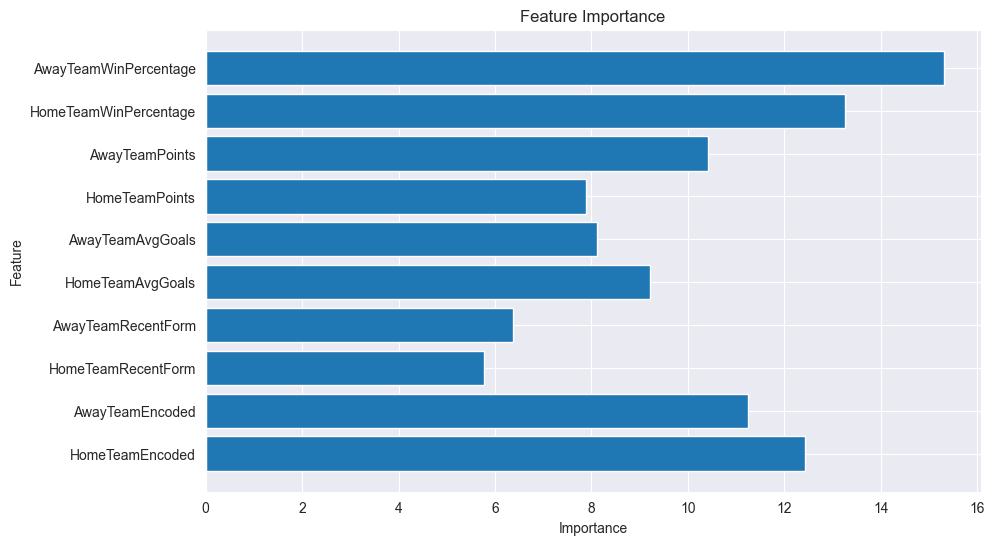

In [49]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = final_model.get_feature_importance()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


In [50]:
# make predictions for the 2023/24 season
def predict_match(home_team, away_team, final_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage'])
    match.loc[0] = [label_encoder.transform([home_team])[0], label_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = final_model.predict_proba(match_scaled)[0][0]
    away_team_win_prob = final_model.predict_proba(match_scaled)[0][2]
    draw_prob = final_model.predict_proba(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob

predict_match('Ath Madrid', 'Sevilla', final_model, scaler)
predict_match('Inter', 'Lecce', final_model, scaler)
predict_match('Roma', 'Napoli', final_model, scaler)



Ath Madrid win probability: 0.001751644343245497
Sevilla win probability: 0.9700453033113354
Draw probability: 0.02820305234541909
Inter win probability: 0.0028895728662108734
Lecce win probability: 0.7252229896317557
Draw probability: 0.27188743750203337
Roma win probability: 0.8698003882802688
Napoli win probability: 0.061586529220332246
Draw probability: 0.06861308249939883


(0.8698003882802688, 0.061586529220332246, 0.06861308249939883)

In [54]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Addressing Class Imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Tuning
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_smote)

# Best Model Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 625 candidates, totalling 3125 fits
              precision    recall  f1-score   support

           A       0.48      0.68      0.56        37
           D       0.40      0.34      0.37        47
           H       0.72      0.64      0.68        72

    accuracy                           0.56       156
   macro avg       0.53      0.55      0.54       156
weighted avg       0.57      0.56      0.56       156


In [56]:
# make predictions for the 2023/24 season
def predict_match(home_team, away_team, best_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage'])
    match.loc[0] = [label_encoder.transform([home_team])[0], label_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = best_model.predict_proba(match_scaled)[0][0]
    away_team_win_prob = best_model.predict_proba(match_scaled)[0][2]
    draw_prob = best_model.predict_proba(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob


predict_match('Ath Madrid', 'Sevilla', best_model, scaler)


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values